In [4]:
import os
import re
import json
import torch
import warnings
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.metrics import f1_score
from datasets import Dataset, DatasetDict
from typing import Optional, Union, Tuple
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import set_seed
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoConfig, BertPreTrainedModel, BertModel,AutoModel,LlamaPreTrainedModel, RobertaPreTrainedModel,AutoModelForSequenceClassification,RobertaModel, BertForSequenceClassification, RobertaForSequenceClassification
warnings.filterwarnings("ignore")

torch.cuda.empty_cache()  
torch.cuda.ipc_collect()  
from typing import Callable, List, Optional, Tuple, Union

seed=42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
#CLEAN DATA
def cleaner1(tweet):
    # remove usernames
    # tweet = re.sub("@[A-Za-z0-9]+","",tweet)
    tweet = tweet.lower()
    tweet = re.sub("^rt", "", tweet)
    tweet = re.sub("\s[0-9]+\s", "", tweet)
    # remove usernames
    tweet = re.sub("@[^\s]+", "", tweet)
    tweet = re.sub("at_user", "", tweet)
    # remove urls
    tweet = re.sub("pic.twitter.com/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = tweet.replace("url", "")
    tweet = tweet.strip()
    tweet = " ".join(tweet.split())
    return tweet



#BINARY LABELS SENT
def binary_labels(df):
    df= df.replace({'label': {'neg': 0, 'pos': 1}})
    id2label = {0: "NEG", 1: "POS"}
    label2id = {"NEG": 0, "POS": 1}
    return df, id2label, label2id

#MULTICLASS LABELS SENT
def multi_labels(df):
    df= df.replace({"label": {"negative": 0, "positive": 1,"neutral":2}})
    id2label = {0: "NEGATIVE", 1: "POSITIVE", 2:"NEUTRAL"}
    label2id = {"NEGATIVE": 0, "POSITIV": 1, "NEUTRAL":2}
    return df, id2label, label2id


#MULTICLASS LABELS MORAL
def label_multiclass6(df):
    df= df.replace({'label': {'care': 1, 'harm': 1,
                                'fairness': 2,'cheating': 2,
                                'loyalty': 3,'betrayal': 3,
                                'authority': 4,'subversion': 4,
                                 'purity': 5,'degradation': 5,'nonmoral': 0,'nomoral': 0
                                }})
    
    id2label = {0:"NONMORAL", 1:"CARE" ,1:"HARM",2:"FAIRNESS",2:"CHEATING",3:"LOYALTY",3:"BETRAYAL",4:"AUTHORITY",4:"SUBVERSION",5:"PURITY",5:"DEGRADATION"}
    label2id = {"NONMORAL":0, "CARE": 1,"HARM":1,"FAIRNESS":2,"CHEATING":2,"LOYALTY":3,"BETRAYAL":3,"AUTHORITY":4,"SUBVERSION":4,"PURITY":5,"DEGRADATION":5}

    return df, id2label,label2id 

def label_multiclass11(df):
    df= df.replace({'label': {'care': 1, 'harm': 2,
                                'fairness': 3,'cheating': 4,
                                'loyalty': 5,'betrayal': 6,
                                'authority': 7,'subversion': 8,
                                 'purity': 9,'degradation': 10,'nonmoral': 0,'no moral': 0,'nomoral': 0
                                }})
    
    id2label = {0:"NONMORAL", 1:"CARE" ,2:"HARM",3:"FAIRNESS",4:"CHEATING",5:"LOYALTY",6:"BETRAYAL",7:"AUTHORITY",8:"SUBVERSION",9:"PURITY",10:"DEGRADATION"}
    label2id = {"NONMORAL":0, "CARE": 1,"HARM":2,"FAIRNESS":3,"CHEATING":4,"LOYALTY":5,"BETRAYAL":6,"AUTHORITY":7,"SUBVERSION":8,"PURITY":9,"DEGRADATION":10}

    return df, id2label,label2id 
    
# METRICS
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    #print(predictions)
    predictions = np.argmax(predictions, axis=1)
    #print(predictions)
    #print(labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall}


# TOKENIZER
def tokenize_function(examples):
    tokenized_inputs=tokenizer(examples["text"], truncation=True)
    return tokenized_inputs


#https://discuss.huggingface.co/t/combine-bertforsequenceclassificaion-with-additional-features/6523/2
#MODELS


In [6]:
#ROBERTA MODEL (TEXT EMBEDDING + USER EMBEDDING)
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoConfig, AutoModel,RobertaPreTrainedModel,AutoModelForSequenceClassification,RobertaModel,RobertaForSequenceClassification
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size + num_extra_dims  # Correctly add extra dimensions
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels) 


    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomRobertaForSequenceClassification(RobertaPreTrainedModel):
    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.config = config
        self.num_extra_dims = num_extra_dims 
        total_dims = config.hidden_size + num_extra_dims 
        
        # classifier 
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHead(config, num_extra_dims)

        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,  
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        cls_output = sequence_output[:, 0, :] 

        if extra_data is not None:
            cls_output = torch.cat((cls_output, extra_data), dim=-1)

        logits = self.classifier(cls_output)
            
        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, **kwargs):
        """
        Override `from_pretrained` to handle `num_extra_dims` when loading a pre-trained model.
        """
        num_extra_dims = kwargs.pop("num_extra_dims", 0)  # Extract num_extra_dims
        config = kwargs.pop("config", None)

        if config is None:
            config = AutoConfig.from_pretrained(pretrained_model_name_or_path, **kwargs)

        config.num_extra_dims = num_extra_dims  # Inject extra_dims into config

        return super().from_pretrained(
            pretrained_model_name_or_path,
            *model_args,
            config=config,
            num_extra_dims=num_extra_dims,  # Pass it explicitly
            **kwargs
        )


# ROBERTA

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5


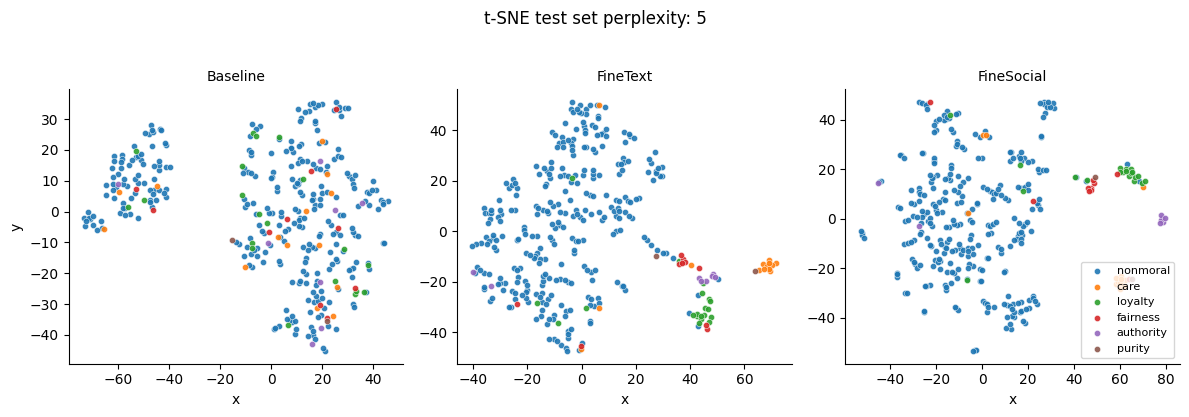

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoConfig, RobertaModel
from transformers import RobertaPreTrainedModel
from torch import nn
#MULTICLASS LABELS MORAL
def label_multiclass6(df):
    df= df.replace({'label': {'care': 1, 'harm': 1,
                                'fairness': 2,'cheating': 2,
                                'loyalty': 3,'betrayal': 3,
                                'authority': 4,'subversion': 4,
                                 'purity': 5,'degradation': 5,'nonmoral': 0,'nomoral': 0
                                }})
    
    id2label = {0:"NONMORAL", 1:"CARE" ,1:"HARM",2:"FAIRNESS",2:"CHEATING",3:"LOYALTY",3:"BETRAYAL",4:"AUTHORITY",4:"SUBVERSION",5:"PURITY",5:"DEGRADATION"}
    label2id = {"NONMORAL":0, "CARE": 1,"HARM":1,"FAIRNESS":2,"CHEATING":2,"LOYALTY":3,"BETRAYAL":3,"AUTHORITY":4,"SUBVERSION":4,"PURITY":5,"DEGRADATION":5}

    return df, id2label,label2id 


# 1. Función de limpieza (ya dada)
import re
def cleaner1(tweet):
    tweet = tweet.lower()
    tweet = re.sub("^rt", "", tweet)
    tweet = re.sub("\s[0-9]+\s", "", tweet)
    tweet = re.sub("@[^\s]+", "", tweet)
    tweet = re.sub("at_user", "", tweet)
    tweet = re.sub("pic.twitter.com/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = tweet.replace("url", "")
    tweet = tweet.strip()
    tweet = " ".join(tweet.split())
    return tweet

# 2. Dataset simplificado para test
class MoralDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, social_feats_column=None):
        self.texts = df['text'].tolist()
        self.labels = df['label'].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.social_feats_column = social_feats_column
        if social_feats_column is not None:
            self.social_feats = df[social_feats_column].tolist()
        else:
            self.social_feats = None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label':          torch.tensor(self.labels[idx], dtype=torch.long),
            'idx':            idx
        }
        if self.social_feats is not None:
            extra = torch.tensor(self.social_feats[idx], dtype=torch.float)
            item['extra_data'] = extra
        return item

# 3. Cargar datos y dividir en train/test (solo necesitamos test para este gráfico)
import pandas as pd
from sklearn.model_selection import train_test_split

tweets = pd.read_pickle("../data/OMC/final_omc_morality.pkl")
tweets['text'] = tweets['text'].map(cleaner1)
tweets['extra_data'] = tweets['deepwalk']
tweets['label'] = tweets['moral_label2']

# 3.2. Etiquetado a 6 clases (si tus labels ya eran ints 0..5, omite)
df, id2label, label2id = label_multiclass6(tweets)

# 3.3. Dividir en train/val/test
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df      = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])

# 4. Cargar tokenizer y DataLoader de test
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base", truncation=True)
test_dataset_base   = MoralDataset(test_df, tokenizer, max_len=128, social_feats_column=None)
test_dataset_text   = MoralDataset(test_df, tokenizer, max_len=128, social_feats_column=None)
test_dataset_social = MoralDataset(test_df, tokenizer, max_len=128, social_feats_column='extra_data')

test_loader_base   = DataLoader(test_dataset_base,   batch_size=32, shuffle=False)
test_loader_text   = DataLoader(test_dataset_text,   batch_size=32, shuffle=False)
test_loader_social = DataLoader(test_dataset_social, batch_size=32, shuffle=False)

# 5. Cargar los 3 modelos en modo eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5.1. Baseline (sin fine-tune): RobertaModel
baseline_model = RobertaModel.from_pretrained("FacebookAI/roberta-base", output_hidden_states=False)
baseline_model.to(device).eval()

# 5.2. Fine-tuned solo texto
config_text = AutoConfig.from_pretrained(
    "../data/omc-roberta-text",
    num_labels=6
)
model_text = CustomRobertaForSequenceClassification.from_pretrained(
    "../data/omc-roberta-text",
    config=config_text,
    num_extra_dims=0
)
model_text.to(device).eval()

# 5.3. Fine-tuned texto+social
config_social = AutoConfig.from_pretrained(
    "../data/omc-roberta-text-deepwalk",
    num_labels=6,
    num_extra_dims=32
)
model_social = CustomRobertaForSequenceClassification.from_pretrained(
    "../data/omc-roberta-text-deepwalk",
    config=config_social,
    num_extra_dims=32
)
model_social.to(device).eval()



emb_base_list   = []
emb_text_list   = []
emb_social_list = []
labels_list     = []

with torch.no_grad():
    for batch_b, batch_t, batch_s in zip(test_loader_base, test_loader_text, test_loader_social):
        # Baseline
        input_b = batch_b['input_ids'].to(device)
        attn_b  = batch_b['attention_mask'].to(device)
        out_b   = baseline_model(input_ids=input_b, attention_mask=attn_b)
        cls_b   = out_b.last_hidden_state[:, 0, :].cpu().numpy()  # (batch_size, 768)

        # FineText
        input_t = batch_t['input_ids'].to(device)
        attn_t  = batch_t['attention_mask'].to(device)
        out_t   = model_text.roberta(input_ids=input_t, attention_mask=attn_t)
        cls_t   = out_t.last_hidden_state[:, 0, :].cpu().numpy()  # (batch_size, 768)

        # FineSocial
        input_s = batch_s['input_ids'].to(device)
        attn_s  = batch_s['attention_mask'].to(device)
        extra_s = batch_s['extra_data'].to(device)
        out_s   = model_social.roberta(input_ids=input_s, attention_mask=attn_s)
        cls_s_t = out_s.last_hidden_state[:, 0, :]                 # (batch_size, 768)
        cls_s   = torch.cat([cls_s_t, extra_s], dim=-1).cpu().numpy()  # (batch_size, 800)

        # Acumular
        labels_b = batch_b['label'].cpu().numpy()
        emb_base_list.extend(cls_b)
        emb_text_list.extend(cls_t)
        emb_social_list.extend(cls_s)
        labels_list.extend(labels_b)

# Convertir a arrays
emb_base_arr   = np.vstack(emb_base_list)   # (num_test, 768)
emb_text_arr   = np.vstack(emb_text_list)   # (num_test, 768)
emb_social_arr = np.vstack(emb_social_list) # (num_test, 800)
labels_arr     = np.array(labels_list)      # (num_test,)

# ------------------------------------------------------------
# 6. t-SNE para cada modelo (perplexity < num_test)
# ------------------------------------------------------------
num_test = emb_base_arr.shape[0]
perp = min(30, num_test - 1)
perp= 5
print(perp)
tsne_base   = TSNE(n_components=2, perplexity=perp, n_iter=1000, metric='cosine', random_state=42)
tsne_text   = TSNE(n_components=2, perplexity=perp, n_iter=1000, metric='cosine', random_state=42)
tsne_social = TSNE(n_components=2, perplexity=perp, n_iter=1000, metric='cosine', random_state=42)

tsne_base_2d   = tsne_base.fit_transform(emb_base_arr)   # (num_test, 2)
tsne_text_2d   = tsne_text.fit_transform(emb_text_arr)   # (num_test, 2)
tsne_social_2d = tsne_social.fit_transform(emb_social_arr) # (num_test, 2)

# ------------------------------------------------------------
# 7. Preparar DataFrame para graficar 1×3
# ------------------------------------------------------------
df_b = pd.DataFrame({
    'x': tsne_base_2d[:, 0],
    'y': tsne_base_2d[:, 1],
    'label': labels_arr,
    'model': ['Baseline'] * num_test
})
df_t = pd.DataFrame({
    'x': tsne_text_2d[:, 0],
    'y': tsne_text_2d[:, 1],
    'label': labels_arr,
    'model': ['FineText'] * num_test
})
df_s = pd.DataFrame({
    'x': tsne_social_2d[:, 0],
    'y': tsne_social_2d[:, 1],
    'label': labels_arr,
    'model': ['FineSocial'] * num_test
})

df_all = pd.concat([df_b, df_t, df_s], ignore_index=True)
# Diccionario de mapeo de etiquetas
label_map = {
    0: "nonmoral",
    1: "care",
    2: "fairness",
    3: "authority",
    4: "loyalty",
    5: "purity"
}

# Crear una nueva columna con las etiquetas de texto
df_all["label_name"] = df_all["label"].map(label_map)

# ------------------------------------------------------------
# 8. Graficar con seaborn (1×3)

g = sns.FacetGrid(df_all, col="model", hue="label_name", palette="tab10", sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=20, alpha=0.9)
#g.add_legend(title="Label")
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f"t-SNE test set perplexity: {perp}", y=1.03)
plt.tight_layout()
plt.legend(fontsize = 8, facecolor = 'w')
#plt.savefig('foo.png', bbox_inches='tight')
plt.savefig('graph5.pdf', bbox_inches='tight')
#plt.savefig("graph5.png")
plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


20


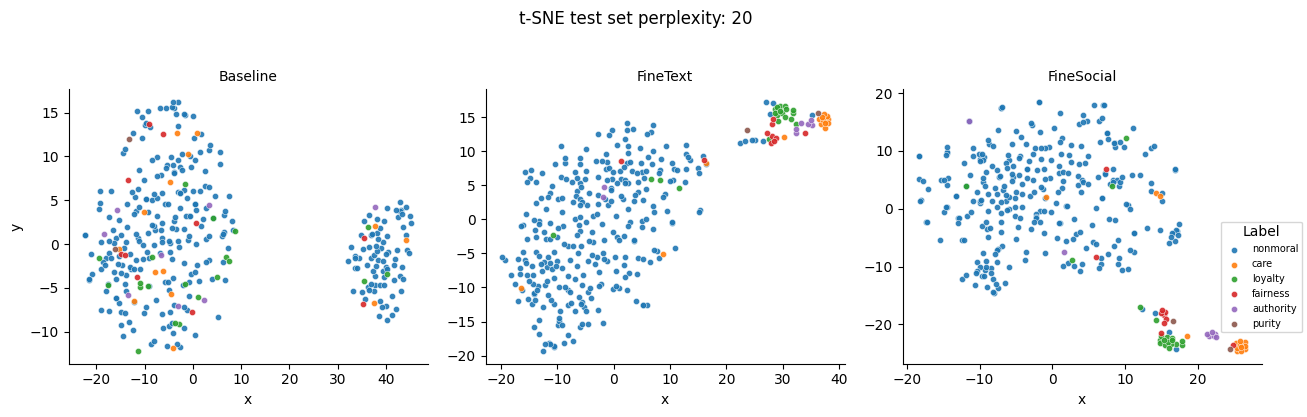

In [50]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoConfig, RobertaModel
from transformers import RobertaPreTrainedModel
from torch import nn
#MULTICLASS LABELS MORAL
def label_multiclass6(df):
    df= df.replace({'label': {'care': 1, 'harm': 1,
                                'fairness': 2,'cheating': 2,
                                'loyalty': 3,'betrayal': 3,
                                'authority': 4,'subversion': 4,
                                 'purity': 5,'degradation': 5,'nonmoral': 0,'nomoral': 0
                                }})
    
    id2label = {0:"NONMORAL", 1:"CARE" ,1:"HARM",2:"FAIRNESS",2:"CHEATING",3:"LOYALTY",3:"BETRAYAL",4:"AUTHORITY",4:"SUBVERSION",5:"PURITY",5:"DEGRADATION"}
    label2id = {"NONMORAL":0, "CARE": 1,"HARM":1,"FAIRNESS":2,"CHEATING":2,"LOYALTY":3,"BETRAYAL":3,"AUTHORITY":4,"SUBVERSION":4,"PURITY":5,"DEGRADATION":5}

    return df, id2label,label2id 


# 1. Función de limpieza (ya dada)
import re
def cleaner1(tweet):
    tweet = tweet.lower()
    tweet = re.sub("^rt", "", tweet)
    tweet = re.sub("\s[0-9]+\s", "", tweet)
    tweet = re.sub("@[^\s]+", "", tweet)
    tweet = re.sub("at_user", "", tweet)
    tweet = re.sub("pic.twitter.com/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = tweet.replace("url", "")
    tweet = tweet.strip()
    tweet = " ".join(tweet.split())
    return tweet

# 2. Dataset simplificado para test
class MoralDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, social_feats_column=None):
        self.texts = df['text'].tolist()
        self.labels = df['label'].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.social_feats_column = social_feats_column
        if social_feats_column is not None:
            self.social_feats = df[social_feats_column].tolist()
        else:
            self.social_feats = None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label':          torch.tensor(self.labels[idx], dtype=torch.long),
            'idx':            idx
        }
        if self.social_feats is not None:
            extra = torch.tensor(self.social_feats[idx], dtype=torch.float)
            item['extra_data'] = extra
        return item

# 3. Cargar datos y dividir en train/test (solo necesitamos test para este gráfico)
import pandas as pd
from sklearn.model_selection import train_test_split

tweets = pd.read_pickle("../data/OMC/final_omc_morality.pkl")
tweets['text'] = tweets['text'].map(cleaner1)
tweets['extra_data'] = tweets['deepwalk']
tweets['label'] = tweets['moral_label2']

# 3.2. Etiquetado a 6 clases (si tus labels ya eran ints 0..5, omite)
df, id2label, label2id = label_multiclass6(tweets)

# 3.3. Dividir en train/val/test
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df      = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])

# 4. Cargar tokenizer y DataLoader de test
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base", truncation=True)
test_dataset_base   = MoralDataset(test_df, tokenizer, max_len=128, social_feats_column=None)
test_dataset_text   = MoralDataset(test_df, tokenizer, max_len=128, social_feats_column=None)
test_dataset_social = MoralDataset(test_df, tokenizer, max_len=128, social_feats_column='extra_data')

test_loader_base   = DataLoader(test_dataset_base,   batch_size=32, shuffle=False)
test_loader_text   = DataLoader(test_dataset_text,   batch_size=32, shuffle=False)
test_loader_social = DataLoader(test_dataset_social, batch_size=32, shuffle=False)

# 5. Cargar los 3 modelos en modo eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5.1. Baseline (sin fine-tune): RobertaModel
baseline_model = RobertaModel.from_pretrained("FacebookAI/roberta-base", output_hidden_states=False)
baseline_model.to(device).eval()

# 5.2. Fine-tuned solo texto
config_text = AutoConfig.from_pretrained(
    "../data/omc-roberta-text",
    num_labels=6
)
model_text = CustomRobertaForSequenceClassification.from_pretrained(
    "../data/omc-roberta-text",
    config=config_text,
    num_extra_dims=0
)
model_text.to(device).eval()

# 5.3. Fine-tuned texto+social
config_social = AutoConfig.from_pretrained(
    "../data/omc-roberta-text-deepwalk",
    num_labels=6,
    num_extra_dims=32
)
model_social = CustomRobertaForSequenceClassification.from_pretrained(
    "../data/omc-roberta-text-deepwalk",
    config=config_social,
    num_extra_dims=32
)
model_social.to(device).eval()



emb_base_list   = []
emb_text_list   = []
emb_social_list = []
labels_list     = []

with torch.no_grad():
    for batch_b, batch_t, batch_s in zip(test_loader_base, test_loader_text, test_loader_social):
        # Baseline
        input_b = batch_b['input_ids'].to(device)
        attn_b  = batch_b['attention_mask'].to(device)
        out_b   = baseline_model(input_ids=input_b, attention_mask=attn_b)
        cls_b   = out_b.last_hidden_state[:, 0, :].cpu().numpy()  # (batch_size, 768)

        # FineText
        input_t = batch_t['input_ids'].to(device)
        attn_t  = batch_t['attention_mask'].to(device)
        out_t   = model_text.roberta(input_ids=input_t, attention_mask=attn_t)
        cls_t   = out_t.last_hidden_state[:, 0, :].cpu().numpy()  # (batch_size, 768)

        # FineSocial
        input_s = batch_s['input_ids'].to(device)
        attn_s  = batch_s['attention_mask'].to(device)
        extra_s = batch_s['extra_data'].to(device)
        out_s   = model_social.roberta(input_ids=input_s, attention_mask=attn_s)
        cls_s_t = out_s.last_hidden_state[:, 0, :]                 # (batch_size, 768)
        cls_s   = torch.cat([cls_s_t, extra_s], dim=-1).cpu().numpy()  # (batch_size, 800)

        # Acumular
        labels_b = batch_b['label'].cpu().numpy()
        emb_base_list.extend(cls_b)
        emb_text_list.extend(cls_t)
        emb_social_list.extend(cls_s)
        labels_list.extend(labels_b)

# Convertir a arrays
emb_base_arr   = np.vstack(emb_base_list)   # (num_test, 768)
emb_text_arr   = np.vstack(emb_text_list)   # (num_test, 768)
emb_social_arr = np.vstack(emb_social_list) # (num_test, 800)
labels_arr     = np.array(labels_list)      # (num_test,)

# ------------------------------------------------------------
# 6. t-SNE para cada modelo (perplexity < num_test)
# ------------------------------------------------------------
num_test = emb_base_arr.shape[0]
perp = min(30, num_test - 1)
perp= 20
print(perp)
tsne_base   = TSNE(n_components=2, perplexity=perp, n_iter=1000, metric='cosine', random_state=42)
tsne_text   = TSNE(n_components=2, perplexity=perp, n_iter=1000, metric='cosine', random_state=42)
tsne_social = TSNE(n_components=2, perplexity=perp, n_iter=1000, metric='cosine', random_state=42)

tsne_base_2d   = tsne_base.fit_transform(emb_base_arr)   # (num_test, 2)
tsne_text_2d   = tsne_text.fit_transform(emb_text_arr)   # (num_test, 2)
tsne_social_2d = tsne_social.fit_transform(emb_social_arr) # (num_test, 2)

# ------------------------------------------------------------
# 7. Preparar DataFrame para graficar 1×3
# ------------------------------------------------------------
df_b = pd.DataFrame({
    'x': tsne_base_2d[:, 0],
    'y': tsne_base_2d[:, 1],
    'label': labels_arr,
    'model': ['Baseline'] * num_test
})
df_t = pd.DataFrame({
    'x': tsne_text_2d[:, 0],
    'y': tsne_text_2d[:, 1],
    'label': labels_arr,
    'model': ['FineText'] * num_test
})
df_s = pd.DataFrame({
    'x': tsne_social_2d[:, 0],
    'y': tsne_social_2d[:, 1],
    'label': labels_arr,
    'model': ['FineSocial'] * num_test
})

df_all = pd.concat([df_b, df_t, df_s], ignore_index=True)
# Diccionario de mapeo de etiquetas
label_map = {
    0: "nonmoral",
    1: "care",
    2: "fairness",
    3: "authority",
    4: "loyalty",
    5: "purity"
}

# Crear una nueva columna con las etiquetas de texto
df_all["label_name"] = df_all["label"].map(label_map)

# ------------------------------------------------------------
# 8. Graficar con seaborn (1×3)

g = sns.FacetGrid(df_all, col="model", hue="label_name", palette="tab10", sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=20, alpha=0.9)

# Agregar la leyenda
g.add_legend(title="Label", fontsize=7)

# Mover la leyenda al costado (derecha)
g._legend.set_bbox_to_anchor((1.02, 0.35))  # (x, y), x > 1 lo pone fuera a la derecha
g._legend.set_frame_on(True)  # poner marco blanco si quieres

g.set_titles(col_template="{col_name}")
g.fig.suptitle(f"t-SNE test set perplexity: {perp}", y=1.03)

plt.tight_layout()

plt.savefig('graph20.pdf', bbox_inches='tight')

plt.show()

